In [18]:
"""
Atividade PEL219 - Multilayer Perceptron - Gabriel Melo. Matrícula: 125.304-6
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from tqdm import tqdm

warnings.filterwarnings('ignore', 'overflow')


## Loss function and activation functions

Coletei as funções de um repositório do github, mas sinceramente n tem nada demais.

In [2]:
def loss(target: np.array, prediction: np.array) -> np.array:
    """
    cross-entropy loss
    https://towardsdatascience.com/courage-to-learn-ml-an-in-depth-guide-to-the-most-common-loss-functions-84a6b07cca17/
    """
    return -target*np.log2(prediction) - (1 - target)*np.log2(1 - prediction)

def d_loss(target: np.array, prediction: np.array) -> np.array:
    """
    cross-entropy derivative loss
    https://towardsdatascience.com/courage-to-learn-ml-an-in-depth-guide-to-the-most-common-loss-functions-84a6b07cca17/
    """
    return -(1/np.log(2))*( (target/prediction) - ((1-target)/(1-prediction)) )
    
def sigmoid(x: np.array) -> np.array:
    """
    sigmoid
    """
    return 1/(1+np.exp(-x))

def d_sigmoid(x: np.array) -> np.array:
    """
    sigmoid derivative
    """
    return sigmoid(x)*(1 - sigmoid(x))

In [3]:
class MLP:
    def __init__(self, layers=(8, 6, 1), lr=0.1, threshold=.5, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.threshold = threshold
        self.layers = layers
        self.weights = []
        self.biases = []
        self.loss = []

    def init_model(self):
        # initialise the model parameters
        for i in range(len(self.layers)-1):
            self.weights.append(np.random.randn(self.layers[i+1], self.layers[i]) * 0.1)  # init layers as 10% size to make it smaller, easier to optmize   
            self.biases.append(np.random.randn(self.layers[i+1], 1) * 0.1)  # init biases as 10% size to make it smaller, easier to optmize   

    def forward(self, X: np.array):
        # BATCH FORWARD PASS, all the results for inference are in the last activation
        input_layer = X
        activations = [input_layer]  # input as first activation layer
        derivatives = [np.zeros(X.shape)]  # input is constant, the derivative is 0

        for i in range(len(self.weights)): # n hidden layers
            net = np.dot(self.weights[i], input_layer) + self.biases[i]
            input_layer = sigmoid(net)
            activations.append(input_layer)
            derivatives.append(d_sigmoid(net))
            
        return activations, derivatives

    def backward(self, activations: list, derivatives: list, y: np.array):
        self.loss.append((1/self.n_class)*np.sum(loss(y, activations[-1]))) # record cross entropy loss for model evaluation
        delta_weights, delta_bias = [], []  # return this to update weights
        
        for i in reversed(range(len(self.weights))):
            if i+1 == len(self.weights):
                error = d_loss(y, activations[i+1])  # cross entropy derivative, all implementations that I've seen on internet are using this error
            else: # hidden layers error
                error = np.dot(self.weights[i+1].T, last_weighted_error)  # error for each hidden layer neuron
            
            # product of the error by the activation derivative, also known as sgd
            weighted_error = np.multiply(error, derivatives[i+1])  
            last_weighted_error = weighted_error
            
            delta_weights.insert(0, (1/self.n_class)*np.dot(weighted_error, activations[i].T))
            delta_bias.insert(0, (1/self.n_class)*np.sum(weighted_error, axis=1))
        
        return delta_weights, delta_bias

    def fit(self, X: np.array, y: np.array):
        self.init_model()
        self.n_class = y.T.shape[1]
        for _ in range(self.epochs):  # loop through each epoch
            # FEED FORWARD
            activations, derivatives = self.forward(X.T)
            # BACKPROPAGATION
            delta_weights, delta_bias = self.backward(activations, derivatives, y.T)
            # UPDATE NETWORK
            for i in range(len(self.weights)):
                self.weights[i] -= self.lr*delta_weights[i]
                self.biases[i]  -= self.lr*delta_bias[i].reshape(-1,1)
            
    def predict(self, X: np.array) -> np.array:
        return np.heaviside(self.forward(X.T)[0][-1] - self.threshold, self.threshold).reshape(-1)
        

# PIMA diabetes dataset

## Perguntas básicas da MLP

* Quantas entradas? R: 8 entradas.
* Quantas saídas? R: classificação binária, não utilizei one hot encoding nesse caso.
* Quantas camadas escondidas? R: Nesse caso, como os dados são mais separáveis, mantive apenas uma camada.
* Quantos neurônios na(s) camada(s) escondida(s)? R: Nesse caso, segui uma regra de utilizar um valor entre as entradas e saídas, neste caso, 6 neurônios. Ref: https://stackoverflow.com/questions/10565868/multi-layer-perceptron-mlp-architecture-criteria-for-choosing-number-of-hidde.
* Como separar os dados de treinamento e teste? R: Utilizei um split de 80% para treino e 20% para teste.
* Como verificar a qualidade do treinamento? R: Utilizei as métricas padrão, matriz de confusão e acompanhei a perda do modelo, nesse caso, cross entropy loss. Ref: https://towardsdatascience.com/courage-to-learn-ml-an-in-depth-guide-to-the-most-common-loss-functions-84a6b07cca17/

In [4]:
# loading the dataset into memory
df_diabetes = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv", header=None) 

X = df_diabetes.iloc[:, :-1].values

scaler = MinMaxScaler((0, 1))

X_scaled = scaler.fit_transform(X)
y = df_diabetes.iloc[:, -1].values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((614, 8), (614,), (154, 8), (154,))

In [6]:
mlp = MLP(epochs=20000, layers=(8, 6, 1))
mlp.fit(x_train, y_train.reshape(-1,1))

In [7]:
results = mlp.predict(x_test).reshape(-1)
target = y_test

In [8]:
print(classification_report(results, target))

              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80        96
         1.0       0.67      0.64      0.65        58

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.74      0.75      0.75       154



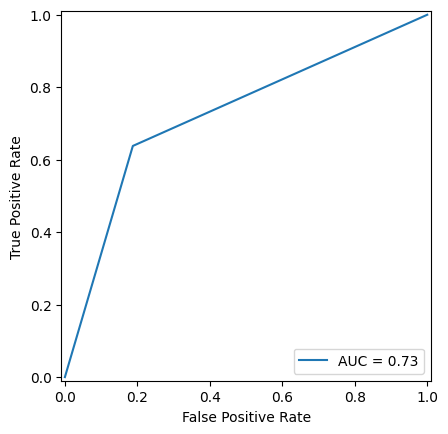

In [9]:
fpr, tpr, thresholds = roc_curve(results, target)

roc_auc = auc(fpr, tpr)

curve = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

curve.plot()

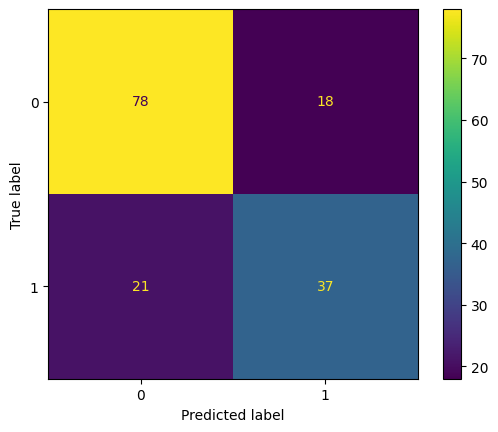

In [10]:
cm1 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(results, target))

cm1.plot()

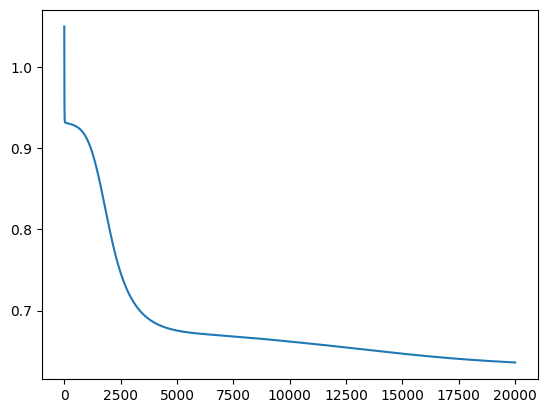

In [11]:
plt.plot(mlp.loss)

# IRIS Fisher dataset

## Perguntas básicas da MLP

* Quantas entradas? R: 4 entradas.
* Quantas saídas? R: 3 classes, utilizei one hot encoding.
* Quantas camadas escondidas? R: Nesse caso, os dados não são linearmente separáveis, usei 2 camadas escondidas, fui testando manualmente, mas não segui uma metodologia tão rigorosa para definir.
* Quantos neurônios na(s) camada(s) escondida(s)? R: Nesse caso, 8 na primeira camada escondida e 6 na segunda camada. Não houve melhora significativa, deixei esses valores para teste da implementação.
* Como separar os dados de treinamento e teste? R: Utilizei um split de 70% para treino e 30% para teste.
* Como verificar a qualidade do treinamento? R: Utilizei as métricas padrão, matriz de confusão e acompanhei a perda do modelo, nesse caso, cross entropy loss. Ref: https://towardsdatascience.com/courage-to-learn-ml-an-in-depth-guide-to-the-most-common-loss-functions-84a6b07cca17/

In [12]:
from sklearn import datasets

iris = datasets.load_iris()

scaler = MinMaxScaler((0,1))

X = scaler.fit_transform(iris['data'])
Y = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(iris['target'].reshape(-1, 1)) # mudo de (x,) para (X, 1)

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)  # um dos melhores resultados foi com o random state igual a 5

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((105, 4), (105, 3), (45, 4), (45, 3))

In [13]:
mlp_iris = MLP(layers=(4, 4, 3), epochs=90000, lr=0.01)
mlp_iris.fit(x_train, y_train)

In [14]:
result_iris = mlp_iris.predict(x_test).reshape(-1, 3)
target = y_test

In [15]:
# return onehotencoded to class label
y_pred_classes = np.argmax(result_iris, axis=1)
y_true_classes = np.argmax(target, axis=1)

# calculate metrics
print(classification_report(y_pred_classes, y_true_classes))


              precision    recall  f1-score   support

           0       0.63      0.43      0.51        28
           1       0.31      0.40      0.35        10
           2       0.08      0.14      0.10         7

    accuracy                           0.38        45
   macro avg       0.34      0.32      0.32        45
weighted avg       0.47      0.38      0.41        45



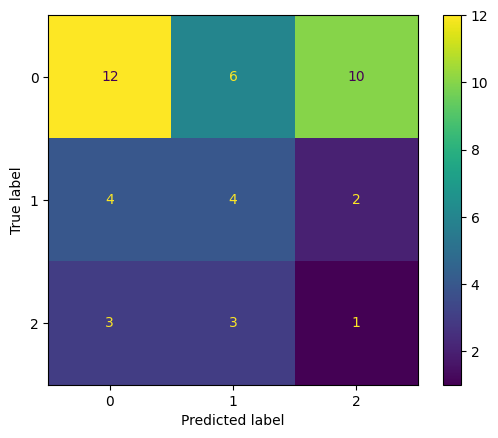

In [16]:
cm_iris = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred_classes, y_true_classes))

cm_iris.plot()

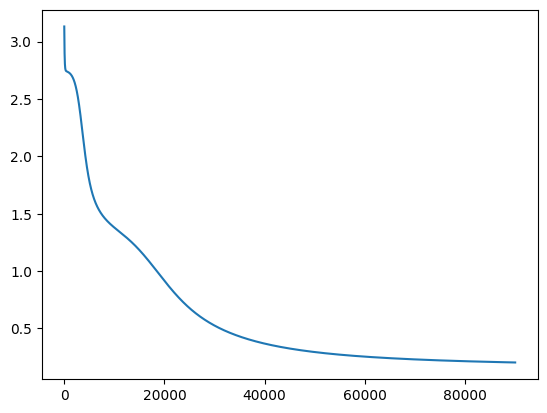

In [17]:
plt.plot(mlp_iris.loss)